In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Read some product review data

In [3]:
products = pd.read_csv("amazon_baby.csv")

# fill missing values with empty string
products.review.fillna("", inplace=True)

# Let's explore this data together

In [4]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


# Build the word count vector for each review

# Exploring the most popular product

In [5]:
products.name.value_counts().reset_index()

,index,name
0,Vulli Sophie the Giraffe Teether,785
1,"Simple Wishes Hands-Free Breastpump Bra, Pink,...",562
2,Infant Optics DXR-5 2.4 GHz Digital Video Baby...,561
3,Baby Einstein Take Along Tunes,547
4,"Cloud b Twilight Constellation Night Light, Tu...",520
...,...,...
32412,Baby Blanket 30 X 35 Inches by Unique Baby (Iv...,1
32413,Bugaboo Frog Stroller - Orange,1
32414,"OXO Tot Sprout Chair Replacement Cushion Set, ...",1
32415,Elmo Travel Tray,1


# Explore Vulli Sophie

In [6]:
giraffe_reviews = products.loc[products.name == 'Vulli Sophie the Giraffe Teether', ]

In [7]:
len(giraffe_reviews)

785

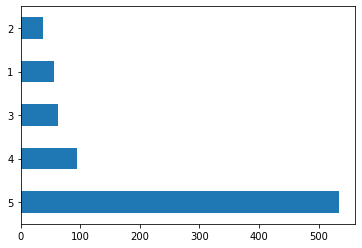

In [8]:
giraffe_reviews.rating.value_counts().plot(kind='barh')
plt.show()

# Build a sentiment classifier

In [9]:
products.rating.describe()

count    183531.000000
mean          4.120448
std           1.285017
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

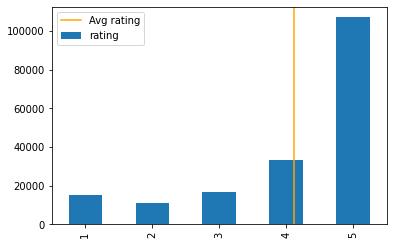

In [12]:
avg_rating = products.rating.mean() - 1 # because ticks starts from "0"
products.rating.value_counts().sort_index().plot(kind='bar')
plt.axvline(avg_rating, color='orange', label='Avg rating')
plt.legend()
plt.show()

## Define what's a positive and a negative sentiment

In [14]:
# ignore all 3* reviews
products = products[products.rating != 3]

# add sentiment column
products['sentiment'] = products.rating >= 4
products.sentiment = products.sentiment.astype('int')

In [15]:
products.head()

,name,review,rating,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,1


# Let's train the sentiment classidier

In [16]:
# we'll use the CountVectorizer to count each vocabulary and put it into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline

In [17]:
pipe = make_pipeline(CountVectorizer(), LogisticRegression(solver='lbfgs', max_iter=150))

In [18]:
pipe

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=150))])

In [19]:
X = products.review
y = products.sentiment

In [20]:
# split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [21]:
# fit the pipeline to the train dataset
pipe.fit(X_train, y_train)

/home/bahram/.virtualenvs/washington/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=150))])

In [22]:
y_pred = pipe.predict(X_test)

**Accuracy Score**: percentage of correct predictions

In [23]:
metrics.accuracy_score(y_test, y_pred)

0.9321459626398009

**Null accuracy**: accuracy that could be achieved by always predicting the most frequent class

In [24]:
products.sentiment.value_counts()[1] / len(products)

0.8411233448474381

## Confusion matrix
Table that describes the perfomance of a clasification model

In [25]:
cm = metrics.confusion_matrix(y_test, y_pred)

In [26]:
pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
Actual 0,3856,1443
Actual 1,820,27232


In [27]:
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).reshape(1, -1)[0]

**Classification Error**: Overall, how oftenis the classifier incorrect?

In [28]:
(FP + FN) / (FP + FN + TN + TP) # or you can find this by 1 - accuracy_score

0.0678540373601991

**Sensitivity**: When the actual value is positive, how often is the prediction correct?
* How "sensitive" is the clasifier to detection positive instances?
* Also known as **True Positive Rate** or **Recall**?

In [29]:
print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred))

0.9707685726507914
0.9707685726507914


**False Positive Rate**: When the acutal value is negative, how often is the prediction incorrect?

In [30]:
FP / (FP + TN)

0.272315531232308

**Precision**: When a positive value is predicted, how often is the prediction correct?

In [31]:
print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred))

0.9496774193548387
0.9496774193548387


## Adjusting the classification threshold

In [32]:
# print the first ten predicted responses
pipe.predict(X_test)[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
# print the first ten predicted probabilities for class 1
pipe.predict_proba(X_test)[:, 1]

array([0.99999759, 0.52423377, 0.99981828, ..., 0.92195854, 0.36722252,
       0.99998745])

In [36]:
# store the predicted probabilities for class 1
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

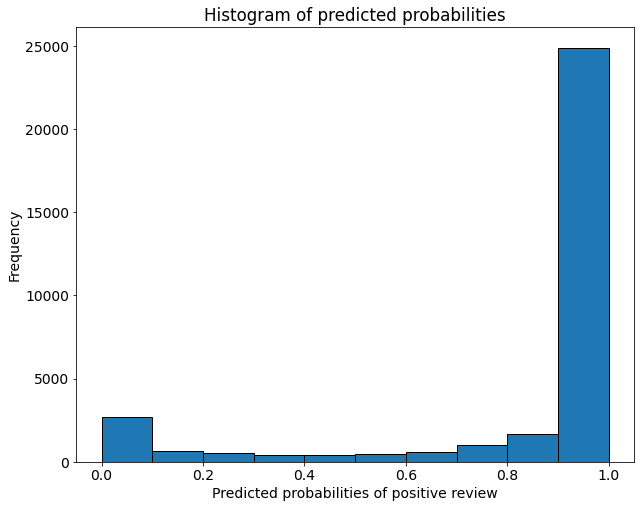

In [37]:
plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 8))

plt.hist(y_pred_proba, edgecolor='black')
plt.title("Histogram of predicted probabilities")
plt.xlabel("Predicted probabilities of positive review")
plt.ylabel("Frequency")
plt.show()

# Evaluate the sentiment model

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

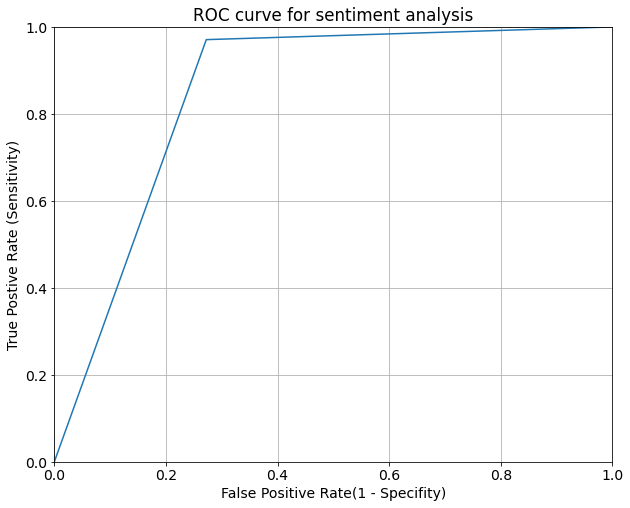

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC curve for sentiment analysis")
plt.xlabel("False Positive Rate(1 - Specifity)")
plt.ylabel("True Postive Rate (Sensitivity)")
plt.grid(True)
plt.show()

# Applying the learned model to understand sentiment for Giraffe

In [41]:
y_pred_proba = pipe.predict_proba(giraffe_reviews.review)[:, 1]

In [49]:
# reset the index for girafe_reviews dataframe and drop index column
giraffe_reviews = giraffe_reviews.reset_index(drop=True)

# append the probability to its dataframe
giraffe_reviews = pd.concat([giraffe_reviews, pd.Series(y_pred_proba, name='predicted_sentiment')], axis=1)

In [50]:
giraffe_reviews.head()

,name,review,rating,predicted_sentiment
0,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5,0.998731
1,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5,0.999150
2,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1,0.606056
3,Vulli Sophie the Giraffe Teether,All the moms in my moms' group got Sophie for ...,5,0.971377
4,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5,0.698227


## Sort the reviews based on the predicted sentiment and explore

In [51]:
# sort by 'rating'; ascending False
giraffe_reviews = giraffe_reviews.sort_values(by='rating', ascending=False).reset_index()

## Explore the most positive

In [52]:
giraffe_reviews.loc[0, 'review']

'He likes chewing on all the parts especially the head and the ears! It has helped when he has been cranky because of teething. Great purchase!'

In [53]:
giraffe_reviews.loc[1, 'review']

'I finally gave in (because I thought it was so cute) and purchased one of these for my daughter.  None of her other teething toys would fit in her mouth. Plus, most of them were hard for her to grip onto. Sophie is perfect. She has so many places to hold and so many small surfaces to chew on. My 2.5 year old also got a major kick out of making the toy squeak. This toy has lasted well after months of use from both a baby and toddler. This is on my list of baby gifts.'

## Show the most negative reviews

In [54]:
review = -3
giraffe_reviews.iloc[-1, review]

"This giraffe is very cute, and I'm sure my daughter would have loved it. But as soon as I received the item (purchased from Dainty Baby) I followed the directions to wash the item with soapy water and a washcloth, and the paint started rubbing off (and I've since read about the same thing happening in other reviews). Whether it's safe (food dye?) paint or not, I'm not comfortable my baby ingesting anything from a toy."

In [55]:
giraffe_reviews.iloc[-2, review]

"I received this as a baby shower gift. I had put it on my registry, due to all the good reviews. I'm a first time soon-to-be parent. When I pulled it out of its fancy box, I could already see the paint coming off of the cheeks and ears of the giraffe. When I rubbed the cheeks with my thumb, more paint came off. I can't imagine the paint won't come off when chewed on by a child. I'm not sure if I'll give it to my baby once he is born. I don't want him chewing and ingesting the paint. It's not worth $17. It's dollar-store quality."